In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
def reset_graph(seed=55):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
gpu_no = '0' # or '1'
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_no

# 定义TensorFlow配置
config = tf.ConfigProto()

# 配置GPU内存分配方式，按需增长，很关键
config.gpu_options.allow_growth = True

# 配置可使用的显存比例
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# 在创建session的时候把config作为参数传进去
sess = tf.InteractiveSession(config = config)

## 从生物神经元到人工神经元

令人惊讶的是，ANN已经存在了好长时间了：最早在1943年由神经学家Warren McCulloch和数学家Walter Pitts提出。在他们著名的论文“A Logical Calculus of Ideas Immanent in Nervous Activity”（ https://goo.gl/Ul4mxW ） [1] 中，McCulloch和Pitts展示了一个简化过的计算模型来描述在动物的大脑中，神经元如何通过命题逻辑来实现复杂的计算。这是第一个人工神经网络架构，正如我们将要看到的，从那之后还有很多其他类型的架构被发明出来。

直到20世纪60年代，ANN的早期成功让人们普遍认为，我们很快将会与真正智能的机器对话。当明确表示这一承诺（至少在一段时间内）将不会实现时，资金就投向了其他地方，ANN进入了漫长的黑暗时期。在20世纪80年代初，随着新网络架构的发明和更好的培训技术的发展，人们对ANN的兴趣又重新变得浓厚。不过到了20世纪90年代，更强大的机器学习技术如支持向量机（见第5章）成为大部分研究者的新宠，因为它们似乎提供了更好的结果和更强大的理论基础。最终，见证了另一波对ANN兴趣的高潮。这次高潮会像上一次那样归于沉寂吗？有很多的原因可以相信这一次会不同，而且会给生活带来很多的影响：

* 现在有了海量的可用数据来训练神经网络，而且在超大超复杂问题上ANN比其他的ML技术性能更佳。
* 自20世纪90年代以来，飞速增长的计算能力使得在合理时间内训练大型神经网络成为可能。部分原因是摩尔定律在生效，不过也要感谢游戏产业，它们制造了数以百万计的强大的GPU。
* 训练算法也得到了很大的提升。坦白说与20世纪90年代相比，算法只有一点点不同，但是这些小的调整产生了巨大的正面影响。
* ANN的一些理论限制在实践中被证明是可以接受的。比如，很多人认为训练算法是注定要失败的，因为算法在局部优化时很可能被卡住，不过这种情况在实践中非常少见（或者即使出现了，它们往往和全局优化值已经非常接近）。
* ANN似乎进入了资金和技术进步的良性循环。基于ANN的惊人产品不断地出现在头条，从而吸引更多的关注和资金投入，这又会使其产生新的进步，然后产生更多令人惊讶的产品。

## 生物神经元

在讨论人工神经元之前，先来快速看一下生物神经元（如图10-1所示）。这是一种通常会出现在动物的大脑皮层中的非凡细胞（比如在你的大脑中），由包含细胞核和大部分细胞复合成分的细胞体组成，有许多分枝延伸的部分称为树突，一个非常长的延伸称为轴突。轴突的长度可能比细胞体长几倍，或者长达几万倍。在其极端附近，轴突分裂成许多被称为终树突的分支，在这些分支的尖端是称为突触终端（或简单的突触）的微小结构，它会连接到其他神经元的树突（或直接连接到细胞体）。生物神经元通过这些突触接受从其他细胞发来的很短的电脉冲，这种脉冲被称为信号。当一个神经元在一定的时间内收到足够多的信号，就会出发它自己的信号。

![图10-1：生物神经元](images/VNote/20201224170130664_15304.png)

图10-1：生物神经元 [2]

单个的生物神经元看起来非常简单，但是数以亿计的神经元组成了一个巨大的网络，每个神经元都会与数千个其他的神经元链接。超级复杂的计算也可以通过这些简单的神经元来完成。生物神经网络架构 [3] 仍然是一个非常活跃的研究主题，不过大脑的部分区域已经被映射好了，神经元往往会按照连续的层次来组织，如图10-2所示。

![图10-2：生物神经网络的多个层次（人类大脑皮层）](images/VNote/20201224173421868_6121.png)

图10-2：生物神经网络的多个层次（人类大脑皮层） [4]

## 具有神经元的逻辑计算

Warren McCulloch和Walter Pitts提出了一个生物神经元的简化模型，这种模型后来被称为人工神经元：它有一个或多个二进制（开/关）的输入和一个二进制输出。当一定数量的输入都是激活状态时，人工神经元就会激活其输出。McCulloch和Pitts展示了即使用如此简单的模型，也可能构建一个可以计算任意复杂逻辑的网络出来。举个例子，来构建一个执行多种逻辑计算的人工神经网络（见图10-3），假设当一个神经元的至少两个输入是激活状态时它自身就会处于激活状态。

![图10-3：计算简单逻辑计算的人工神经网络](images/VNote/20201224173551911_9920.png)

图10-3：计算简单逻辑计算的人工神经网络

* 左侧的第一个网络是一个简单的等同函数：如果神经元A是激活的，那么C就是激活的（它从A接受了两个输入信号），如果A是非激活的，则C也是非激活的。
* 第二个网络计算逻辑与：只有当A和B都处于激活状态，C才会激活（单独的一个输入并不足以激活C）。
* 第三个网络计算逻辑或：A和B中有一个（或者两者都）处于激活时，C就会被激活。
* 最后，假设输入可以抑制神经元的激活状态（正如生物神经网络中那样），那么第四个网络计算的就是一个比较复杂的逻辑操作：只有在A是激活而且B是非激活时，神经元C才会处于激活状态。如果A一直处于激活，那你就得到了逻辑非：当B非激活时，C激活，反之亦然。

想象用这些网络如何组合出更复杂的逻辑计算（练习见章节末尾处）。

## 感知器

感知器是最简单的ANN架构之一，于1957年由Frank Rosenblatt发明。它基于一个稍微不同的被称为线性阈值单元（LTU）的人工神经元（见图10-4）：输入和输出都是数字（而不是二进制的开关状态），每个输入的连接都有一个对应的权重。LTU会加权求和所有的输入（$z=w_1x_1 + w_2x_2 + \dots +w_nx_n = w^T \cdot x$），然后对求值结果应用一个阶跃函数（step funciton）并产生最后的输出：$h_w(x) = step(z) = step(w^T \cdot x)$。

感知器中最常见的阶跃函数叫作Heaviside阶跃函数（见公式10-1），有时候会使用带符号的函数。

![图10-4：线性阈值单元](images/VNote/20201225101922344_25536.png)

图10-4：线性阈值单元

$$
heaviside(z) = \begin{cases}
    0 & (z < 0) \\
    1 & (z \geq 0)
\end{cases} \\
sgn(z) = \begin{cases}
    -1 & (z<0) \\
    0 & (z=0) \\
    1 & (z>0)
\end{cases} \tag{10-1} \label{10-1}
$$
公式10-1：感知器中常见的阶跃函数

单个LTU可以用来做简单的线性二值分类。它计算输入的线性组合，如果结果超出了阈值，输出就是正否则为负（与逻辑回归分类器或者线性支持向量机一样）。举个例子，可以用一个LTU来根据花瓣的长度和宽度分类鸢尾花（正如我们在上一章做的，添加一个$x_0 =1$偏差）。训练LTU的意思是寻找$w_0$ 、$w_1$ 和$w_2$ 的正确值（训练算法待会讨论）。 

感知器就是个单层的LTU [5] ，每个神经元都与所有输入相连。这些连接通常使用称为输入神经元的特殊传递神经元来表示：输入什么就输出什么。此外，还会加上一个额外的偏差特征（$x_0 =1$）。偏差特征通常用偏差神经元来表示，它永远都只输出1。

图10-5展示了一个有两个输入和三个输出的感知器。这个感知器可以将实例同时分为三个不同的二进制类，因此它被称为多输出分类器。

![图10-5：感知器图](images/VNote/20201225103530204_2459.png)

图10-5：感知器图

那么感知器是如何被训练的呢？Frank Rosenblatt提出的感知器训练算法很大程度上受到Hebb’s定律的启发。在他1949年出版的著作《行为的组织》中，Donald Hebb提到如果一个生物神经元总是触发另外的神经元，那么这两个神经元之间的连接就会变得更强。这个想法后来被Siegrid Lowel总结为：同时处于激活状态的细胞是会连在一起的。这个规律后来变成了著名的Hebb定律（又叫Hebbian学习）：当两个神经元有相同的输出时，它们之间的连接权重就会增强。感知器就是使用这个规则的变体进行训练，该变种还考虑了网络错误，对于导致错误输出的连接，它不会加强该连接的权重。更具体地说，感知器一次供给一个训练实例，并且对于每个实例它都会进行预测。对于产生错误预测的每个输出神经元，它加强了来自输入的连接权重，这将对正确的预测做出贡献。规则见公式10-2。

公式10-2：感知器学习规则（权重更新）

$$
w_{i,j}^{(next\_step)} = w_{i,j} + \eta(\hat y_j -y_j)x_i \tag{10-2} \label{10-2}
$$

* $w_{i，j}$是第$i$个输入神经元和第$j$个输出神经元的连接权重。
* $x_i$ 是当前训练实例的第$i$个输入值。
* $\hat y_j$ 是当前训练实例的第$j$个输出神经元的输出。
* $y_j$ 是当前训练实例的第j个输出神经元的目标输出。
* $\eta$是学习速率。

每个输出神经元的决策边界是线性的，所以感知器无法学习复杂的模式（这点和逻辑回归分类器一样）。Rosenblatt证明如果训练实例是线性可分的，这个算法会收敛到一个解 [6] 。这被称为`感知器收敛定理`。

Scikit-Learn提供了一个实现单一LTU网络的Perceptron类。它基本可以在鸢尾花数据集上如期工作（见第4章）：

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=100, tol=-np.infty, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

Perceptron(max_iter=100, random_state=42, tol=-inf)

In [5]:
# random_state改成55就会出现不同的预测结果。
y_pred

array([1])

可能已经注意到感知器学习算法酷似随机梯度下降法。事实上，在Scikit-Learn里，Perceptron类的行为等同于使用以下超参数的`SGDClassifier`：`loss="perceptron"`，`learning_rate="constant"`，`eta0=1`（学习速率），以及`penalty=None`（不做正则化）。

> 和逻辑回归分类器相反，感知器不输出某个类概率。它只能根据一个固定的阈值来做预测。这也是更应该使用逻辑回归而不是感知器的一个原因。

在1969年的名为《感知器》的专著中，Marvin Minsky和Seymour Papert强调了感知器的一系列缺点，特别是它无法处理的一些很微小的问题，比如异或分类问题（XOR），见图10-6左侧。当然这个问题在其他任何的线性分类模型中一样存在，只不过研究者对感知器的期望太高，因此失望也更大：结果就是，很多研究者完全放弃连接机制（connectionism，即神经网络的研究），而倾向于更高层次的问题，如逻辑、问题解决和搜索。

不过，事实证明感知器的一些限制可以通过将多个感知器堆叠起来的方式来消除，这种形式的ANN就是多层感知器（Multi-Layer Perceptron）。实践中，MLP可以解决异或问题，比如可以计算一下图10-6中的MLP的结果来验证：对于输入的不同组合，（0，0）或者（1，1）会产生0，而（0，1）或者则产生1。

![图10-6：异或分类问题和用来解决它的MLP](images/VNote/20201225111431021_3265.png)

图10-6：异或分类问题和用来解决它的MLP

In [6]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

<Figure size 720x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Activation function: heaviside')

<AxesSubplot:>

Text(0.5, 1.0, 'Activation function: sigmoid')

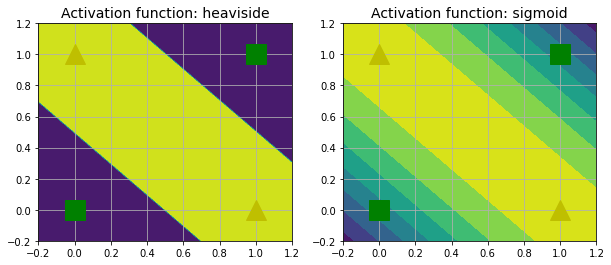

In [7]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## 多层感知器和反向传播

一个MLP包含一个（透传）输入层，一个或者多个被称为隐藏层的LTU层，以及一个被称为输出层的LTU组成的最终层（见图10-7）。除了输出层之外，每层都包含了一个偏移神经元，并且与下一层完全相连。如果一个ANN有2个以及2个以上的隐藏层，则被称为`深度神经网络`（DNN）。

![图10-7：多层感知器](images/VNote/20201225111808554_27357.png)

图10-7：多层感知器

多年来，研究者都为如何训练MLP而头疼不已，一直没有进展。直到1986年，D.E.Rumelhart发表了一篇介绍`反向传播训练算法` [7] 的开创性论文（ https://goo.gl/Wl7Xyc ） [8] 。今天称其为使用了反向自动微分的梯度下降法（梯度下降在第4章介绍过，自动微分在第9章介绍过）。

对于每一个训练实例，算法将其发送到网络中并计算每个连续层中的每个神经元的输出（这是正向过程，与做预测的过程一样）。然后它会度量网络的输出误差（对比期望值和实际的网络输出），然后它会计算最后一个隐藏层中的每个神经元对输出神经元的误差的贡献度。之后它继续测量这些误差贡献中有多少来自前一个隐藏层中的每个神经元，这个过程一直持续到输入层（也就是第一层）。这个反向传递过程通过在网络中向后传播误差梯度有效地测量网络中所有连接权重的误差梯度（这也是它名字的来源）。如果看一下附录D中的反向自动微分算法，会发现反向传播的正向和反向传递都只是简单地执行反向模式的自动微分。反向传播算法的最后一步是对网络中所有连接权重执行梯度下降法，使用之前度量的误差梯度。

简而言之：对于每个训练实例，反向传播算法先做一次预测（正向过程），度量误差，然后反向的遍历每个层次来度量每个连接的误差贡献度（反向过程），最后再微调每个连接的权重来降低误差（梯度下降）。

为了让这个算法正常工作，作者对MLP架构做了一个关键的调整：把阶跃函数改成了逻辑函数：$\theta(z) = 1/(1 + \exp(-z))$。这是非常关键的一步，因为阶跃函数只包含平面，所以没有梯度（梯度下降在平面上无法移动），但是逻辑函数则有着定义良好的偏导，梯度下降可以在每一步都做调整。除了逻辑函数，反向传播算法还可以和其他激活函数一起使用。最流行的两个`激活函数`是：

*双曲正切函数*：$\tanh(z)=\frac{\exp(z) - \exp(-z)}{\exp(z) + \exp(-z)}$

与逻辑函数类似，它是一个S形曲线，连续且可微分，不过它的输出是-1到1之间的值（逻辑是0到1之间的值），这会让每层的输出在训练开始时或多或少地标准化（以0为中心）。这通常有助于快速融合。

*ReLU函数*（在第9章介绍过）:$ReLU(z) = \max(0,z)$。

这个函数也是连续的，不过在$z=0$时不可微分（坡度的突然变化可以使梯度下降反弹）。不过实践中它工作良好，而且计算速度很快。最重要的是，由于它没有最大输出值，对于消除梯度下降的一些问题很有帮助（将在第11章详细讨论）

这些常见激活函数和它们的导数如图10-8所示。

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Activation functions')

(-5.0, 5.0, -1.2, 1.2)

<AxesSubplot:>

Text(0.5, 1.0, 'Derivatives')

(-5.0, 5.0, -0.2, 1.2)

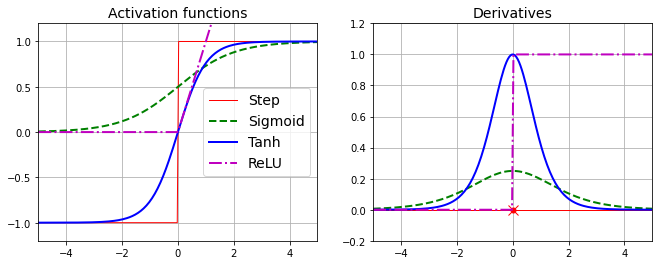

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("activation_functions_plot")
plt.show()

图10-8：激活函数和它们的导数

MLP常常被用来做分类，每个输出对应一个不同的二进制分类（比如，垃圾邮件/正常邮件、紧急/非紧急，等等）。当每个分类是互斥的情况下（比如将图片分类为数字0～9的场景），输出层通常被修改成一个共享的softmax函数（见图10-9）。softmax函数在第3章介绍过。每个神经元的输出对应于相应分类的估计概率。注意信号是单向流动的（从输入流向输出），所以这种架构是前馈神经网络（FNN）的一个范例。

> 生物神经元貌似实现了一个粗糙的S形激活函数，所以研究者花了很长时间在S形函数上。但事实证明，ReLU激活函数通常在ANN中工作得更好，这是被生物类比误导的案例之一。

![图10-9：用以分类的现代MLP（包含ReLU和softmax）](images/VNote/20201225133806396_31080.png)

图10-9：用以分类的现代MLP（包含ReLU和softmax）

[1] “神经活动中内在思想的逻辑演算”，W.McCulloch和W.Pitts（1943）。

[2] 图片由Bruce Blaus拍摄（知识共享3.0，https://creativecommons.org/licenses/by/3.0/），转载自https://en.wikipedia.org/wiki/Neuron。

[3] 在机器学习的上下文中，“神经网络”一般指的是人工神经网络，而不是生物神经网络。

[4] 由S.Ramon y Caja（l公共领域）绘制大脑皮质层。转载自https://en.wikipedia.org/wiki/Cerebral_cortex。

[5] Perceptron有时用来表示具有单个LTU的小型网络。

[6] 注意答案往往不唯一，通常来说，如果数据是线性可分的，那么总有一个无线的超平面可以划分它们。

[7] “通过错误传播学习内部表示”，D.Rumelhart、G.Hinton和R.Williams（1986）。

[8] 该算法实际由不同领域的多个研究人员发明，从1974年，P.Werbos的研究开始。

## 用TensorFlow的高级API来训练MLP

用TensorFlow训练MLP的最简单方式是使用它的高级API TF.Learn，这和Scikit-learn的API非常类似。用DNNClassifier类来训练一个有着任意数量隐藏层，并包含一个用来计算类别概率的softmax输出层的深度神经网络都易如反掌。比如，下面的代码训练一个用于分类有两个隐藏层（一个有300个神经元，另一个有100个），以及一个softmax输出层的具有10个神经元的DNN：

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [11]:
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptq2ehbvi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and 

如果在MNIST数据集来执行上面的代码（缩放之后，例如使用Scikit-Learn的StandardScaler来缩放），你可以得到一个在测试集上的准确率达到98.1%的模型！这比第3章里最好的模型还要好：

In [12]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results = dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-12-29T20:16:50Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptq2ehbvi/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.55227s
INFO:tensorflow:Finished evaluation at 2020-12-29-20:16:51
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9801, average_loss = 0.097413175, global_step = 44000, loss = 12.330782
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44000: /tmp/tmptq2ehbvi/model.ckpt-44000


In [13]:
eval_results

{'accuracy': 0.9801,
 'average_loss': 0.097413175,
 'loss': 12.330782,
 'global_step': 44000}

在幕后，`DNNClassifier`类基于ReLU激活函数（可以通过设置`activation_fn`超参数来调整）创建所有的神经元层次。输出层依赖于softmax函数，成本函数是交叉熵（详见第4章）。

> TF.Learn API还是比较新的，所以在阅读本书时，例子中使用的名称和函数可能会有所发展，不过基本的理念是不变的。

## 使用纯TensorFlow训练DNN

如果想对网络的架构有更多的控制，可以使用TensorFlow的低级Python API（见第9章）。在本节用低级API构建一个和上一节相同的模型，实现一个小批次梯度下降来训练MNIST数据集。首先是构建阶段，建立TensorFlow的计算图，第二步是执行阶段，具体运行这个图来训练模型。

### 构建阶段

首先需要引入TensorFlow库，然后是指定输入和输出的个数，并设置每层的隐藏神经元的个数：

In [14]:
#import tensorflow as tf

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

接下来，与第9章一样，可以使用占位符节点来表示训练数据和目标。X的形状只做了部分定义。它是一个二维的张量（一个矩阵），一个维度是实例，另一个维度是特征，还知道特征的数量为28×28（每个像素一个特征），但是还不知道每个训练批次将包含多少个实例。因此X的形状为（None，n_inputs）。类似y是一个一维的张量，每个实例都有一个入口，但是我们现在还不知道训练批次的大小，所以形状是None。

In [15]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

现在创建神经网络。占位符节点X将用作输入层；在执行期，它每次都会被训练批次替换（注意训练批次中的所有实例将由神经网络同时处理）。然后创建两个隐藏层和一个输出层。两个隐藏层基本上是一样的：唯一的区别是它们和谁链接，以及每层中包含的神经元数量。输出层也一样，不过它会用softmax而不是ReLU作为激活函数。创建一个`neuron_layer()`函数来每次创建一个层。它需要的参数包括：输入、神经元数量、激活函数、层次的名字：

In [16]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

逐行看一下这段代码：

1. 首先通过层的名称来创建一个作用域：它将包含该层的所有计算机节点。这是可选的，不过如果节点组织得很好，在TensorBoard上图看起来会好看一些。
2. 通过查看输入矩阵的形状并获取第二个维度（第一个维度对应的是实例）的尺寸来决定输入的数量。
3. 接下来的三行创建了一个保存权重矩阵的变量W。它是一个二维张量包含了每个输入和每个神经元间连接的权重；因此，它的形状是`(n_inputs，n_neurons)`。使用标准偏差为$2/\sqrt{n_{inputs}}$的截断 [1] 正态（高斯）分布进行随机初始化。使用一个指定的标准偏差会让算法收敛得更快（在第11章会进一步讨论，这种通过微小调整就会获得巨大收益的做法）。为所有隐藏层随机地初始化连接权重值是非常重要的，这可以避免任何可能导致梯度下降出现无法终止的对称性。 [2]
4. 下一行创建了变量b来表示偏差，初始化为0（这里没有对称性问题），每个神经元有一个偏差参数。
5. 创建一个子图$z=X \cdot W+b$。对于批次中的所有实例，该向量实现仅通过一次计算，就能够有效计算每层的每个神经元的输入加上偏差项的权重之和。
6. 最后，如果激活参数设置了`"relu"`，代码会返回$relu(z)$（即，$\max(0，z)$），否则会直接返回$z$。

好了，现在有了一个很棒的创建神经元的函数了。我们来用它创建一个深度神经网络吧！第一个隐藏层需要X作为其输入。第二层则以第一层的输出作为输入。最后，输出层以第二层的输出作为输入：

In [17]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

In [18]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [19]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [20]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [21]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [22]:
n_epochs = 40
batch_size = 50

In [23]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [24]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

0 Batch accuracy: 0.96 Val accuracy: 0.9166
1 Batch accuracy: 0.96 Val accuracy: 0.934
2 Batch accuracy: 0.96 Val accuracy: 0.9434
3 Batch accuracy: 1.0 Val accuracy: 0.9454
4 Batch accuracy: 0.96 Val accuracy: 0.9504
5 Batch accuracy: 0.92 Val accuracy: 0.953
6 Batch accuracy: 0.96 Val accuracy: 0.9588
7 Batch accuracy: 0.96 Val accuracy: 0.9594
8 Batch accuracy: 0.98 Val accuracy: 0.9632
9 Batch accuracy: 0.96 Val accuracy: 0.9654
10 Batch accuracy: 0.98 Val accuracy: 0.967
11 Batch accuracy: 0.94 Val accuracy: 0.9676
12 Batch accuracy: 1.0 Val accuracy: 0.9698
13 Batch accuracy: 0.98 Val accuracy: 0.9694
14 Batch accuracy: 0.98 Val accuracy: 0.9704
15 Batch accuracy: 1.0 Val accuracy: 0.971
16 Batch accuracy: 0.98 Val accuracy: 0.973
17 Batch accuracy: 0.98 Val accuracy: 0.9722
18 Batch accuracy: 1.0 Val accuracy: 0.9736
19 Batch accuracy: 0.98 Val accuracy: 0.9744
20 Batch accuracy: 1.0 Val accuracy: 0.9752
21 Batch accuracy: 1.0 Val accuracy: 0.9744
22 Batch accuracy: 1.0 Val accu

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./models/my_model_final.ckpt") # or better, use save_path
    #X_new_scaled = X_test[:20]
    X_new_scaled = X_test
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt


In [26]:
print("Predicted classes:", y_pred[:20])
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [27]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())

> 使用了命名空间来保持名字的清晰。另外，logits是经过softmax激活函数之前神经网络的输出：基于优化的考虑，将在稍后处理softmax计算。

TensorFlow提供了很多便利的函数来创建标准神经网络层，所以通常无须定义自己的`neuron_layer()`函数。比如TensorFlow的`fully_connected()`函数会创建全连接层，其中所有输入都连接到该层中的所有神经元。这个函数会创建权重和偏差变量，使用合适的初始化策略，使用ReLU激活函数（可以通过activation_fn参数来修改）。它还支持规则化和归一化参数。用`fully_connected()`[新版本使用`dense()`]函数来替换自己写的`neuron_layer()`函数，只需要导入函数并替换掉DNN的构造即可：

In [28]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [29]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [30]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    #logits = tf.keras.layers.Dense(hidden2, n_outputs, name="outputs")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


> tensorflow.contrib包里包含了很多有用的函数，不过其中很多代码都是实验性质的，还没有被正式收录到TensorFlow的API中。fully_connected（）（以及其他很多contrib包中的代码）函数将来可能会变更。

已经有了神经网络模型，现在需要定义成本函数用以训练它。正如第4章做的Softmax回归，这里会使用交叉熵。之前讨论过，交叉熵会处罚那些估计目标类的概率较低的模型。TensorFlow提供了很多函数来计算交叉熵，这里用`spare_soft_max_cross_entropy_with_logits()`：它会根据“logits”来计算交叉熵（比如，在通过softmax激活函数之前网络的输出），并且期望以0到分类个数减1的整数形式标记（例子中是从0到9）。这会计算出一个包含每个实例的交叉熵的一维张量。可以使用TensorFlow的`reduce_mean()`函数来计算所有实例的平均交叉熵。

In [31]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

> 函数`sparse_softmax_cross_entropy_with_logits()`与先应用softmax函数再计算交叉熵的效果是一样的，不过它更高效一些，另外它会处理一些边界值如logits等于0的情况。这也是为什么之前没有使用softmax激活函数的原因。此外还有一个`softmax_cross_entropy_with_logits()`函数，它以one-hot的形式获取标签（而不是从0到分类数量减1）。

现在有了神经网络模型，有了成本函数，是时候来定义一个`梯度下降优化器`（`GradientDescentOptimizer`）了，这个优化器会调整模型的参数来使得成本函数的值最小化。

In [32]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

构建期的最后一个重要步骤是指定如何对模型求值。简单地将精度用作性能指标。首先，对于每个实例，通过检查最高logit值是否对应于目标类来确定神经网络的预测是否正确。这里可以使用`in_top_k()`函数，这个函数会返回一个一维的张量，其值为布尔类型，因此需要将值强制装换成浮点型然后计算平均值，这会得出网络的总体精度。

In [33]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

与往常一样，创建节点初始化变量，创建Saver将训练后的模型保存到磁盘：

In [34]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

好了！构建期终于结束了。一共不到40行代码，不过很清晰：1. 创建了用于输入和目标值占位符节点，2. 创建了用以创建神经网络的函数，使用它创建DNN，3. 定义了成本函数，4. 创建了一个优化器，5. 最后还定义了性能度量。现在我们进入执行期。

### 执行阶段

这部分会短很多，也简单很多。首先，加载MNIST数据集。可以像上一章一样用Scikit-Learn，不过TensorFlow提供了自己的助手函数来加载数据，缩放（从0到1），打乱，还提供了一个简单函数每次加载一个小批次。这里用TensorFlow提供的函数：

然后定义需要运行的epoch数量，以及小批次大小：

In [35]:
n_epochs = 20
n_batches = 50

现在就可以训练模型了：

In [36]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./models/my_model_final.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.9032
1 Batch accuracy: 0.96 Validation accuracy: 0.9232
2 Batch accuracy: 0.96 Validation accuracy: 0.9348
3 Batch accuracy: 0.98 Validation accuracy: 0.9394
4 Batch accuracy: 0.98 Validation accuracy: 0.945
5 Batch accuracy: 0.92 Validation accuracy: 0.9488
6 Batch accuracy: 0.98 Validation accuracy: 0.954
7 Batch accuracy: 0.96 Validation accuracy: 0.9586
8 Batch accuracy: 0.96 Validation accuracy: 0.96
9 Batch accuracy: 0.92 Validation accuracy: 0.9616
10 Batch accuracy: 0.94 Validation accuracy: 0.9642
11 Batch accuracy: 0.94 Validation accuracy: 0.9654
12 Batch accuracy: 0.96 Validation accuracy: 0.9668
13 Batch accuracy: 0.96 Validation accuracy: 0.9676
14 Batch accuracy: 0.98 Validation accuracy: 0.9686
15 Batch accuracy: 0.98 Validation accuracy: 0.9694
16 Batch accuracy: 0.96 Validation accuracy: 0.9712
17 Batch accuracy: 0.96 Validation accuracy: 0.9716
18 Batch accuracy: 1.0 Validation accuracy: 0.9718
19 Batch accuracy: 0.98 Val

上面的代码先打开了一个TensorFlow的会话，运行初始化代码来初始化所有的变量。运行主训练循环：在每一个周期（epoch）中，迭代一组和训练集大小相对应的批次，每一个小批次通过`next_batch()`方法来获得，然后执行训练操作，将当前小批次的输入数据和目标传入。接下来，在每个周期结束的时候，代码会用上一个小批次以及全量的训练集来评估模型，并打印结果。最后，将模型的参数保存到硬盘。

### 使用神经网络

现在神经网络已经被训练好了，可以用它来做预测了。保留构建器的代码，修改执行期的代码如下所示：

In [37]:
with tf.Session() as sess:
    saver.restore(sess, "./models/my_model_final.ckpt") # or better, use save_path
    #X_new_scaled = X_test[:20]
    X_new_scaled = X_test
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./models/my_model_final.ckpt


In [38]:
y_pred[20:40]
y_test[20:40]

array([9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1])

array([9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1],
      dtype=int32)

上面的代码首先从硬盘上加载模型参数，然后加载需要被分类的新图片。记住应用与训练数据相同的特征缩放（这里是从0到1）。然后评估logits节点。如果想知道所有分类的概率，可以给logits使用`softmax()`函数，如果只是想预测一个分类，只需要选出那个有最大logit值的即可（可以使用`argmax()`函数完成）。

[1] 使用截断的正态分布而不是常规的正态分布，保证这里不存在任何减慢训练的大权重。

[2] 例如，如果将所有的权重设置为0，然后所有的神经元输出为0，对于给定隐藏层的所有神经元，误差梯度也是相同的。然后梯度下降步骤在每一层以相同的方式更新所有神经元的权重，因此它们将保持相等。换句话说，尽管每层有数百个神经元，但是模型的每层就好像只有一个神经元一样。

## 微调神经网络的超参数

神经网络的灵活性也恰好是它的一个主要的短板：有太多的超参数需要调整。不仅仅是可以使用任何的网络拓扑（神经元是如何彼此连接的），即使是简单的MLP，也有很多可以调整的参数：可以修改层数，每层的神经元数，每层用的激活函数类型，初始化逻辑的权重，等等。怎么才能知道超参数的何种组合适合你呢？

当然，正如上一章展示的，可以使用具有交叉验证的网格搜索来查找正确的超参数。不过有如此多的超参数需要调整，另外，在一个大的数据集上训练神经网络会很耗时，在有限的时间内，只可能探索很小一部分超参数。不过用我们在第2章提到的随机搜索法（ https://goo.gl/QFjMKu ）会好很多。另外一个选项是使用像Oscar（ http://oscar.calldesk.ai/ ）这样的工具，它实现了更复杂的算法，可以更快地找出超参数集。

对于缩小搜索空间来说，了解每个超参数的合理取值会很有帮助。从隐藏层的个数开始。

### 隐藏层的个数

对很多问题，可以从单一的隐藏层开始，而且通常可以获得很好的效果。事实上人们发现只要神经元足够多，仅有一个隐藏层的MLP都可以建模大部分复杂的函数。很长一段时间里，研究者们都认为无须进一步研究更深的神经网络。不过他们忽视了深层网络比浅层网络有更高的参数效率：深层网络可以用非常少的神经元来建模复杂函数，因此训练起来更加快速。

要理解为什么会这样，设想你被要求用一个绘图软件画一片森林，但是不允许拷贝粘贴。只能依次画每一棵树，每一个枝干，每一片叶子。如果可以先画一片叶子，然后拷贝粘贴成一个枝干，再拷贝粘贴成一棵树，最后再拷贝粘贴整棵树形成森林，那速度将会大大提高。现实世界的数据往往会按照层次结构组织，而DNN天生的就很擅长处理这种数据：低级隐藏层用以建模低层结构（比如，各种形状和方向的线段），中级隐藏层组合这些低层结构来建模中层结构（比如，正方形、圆形等），高级隐藏层和输出层组合这些中层结构来建模高层结构（比如，人脸）。

分层的架构不但可以帮助DNN更快地归纳出好方案，还可以提高对于新数据集的泛化能力。比如，已经训练出了一个可以识别人脸的模型，现在想要训练一个新的模型来识别发型，可以完全重用第一个模型中的低层神经网络。不必随机初始化新的网络中低层的权重和偏差，可以直接用第一个网络的低层神经网络。这样新网络无须从头在图片中学习所有低层的结构，而只需要从高层结构学习即可（比如发型）。

总之，对于大多数问题来说，都只需要一个或者两个隐藏层来处理（对于MINST数据集，一个拥有数百个神经元的隐藏层就可以达到97%的精度，而用同样数量神经元构建的两层隐藏层就可以获得超过98%的精度，而且训练时间基本相同）。对于更复杂的问题，可以逐渐增减隐藏层的层次，直到在训练集上产生过度拟合。非常复杂的问题，比如大图片的分类，或者语音识别，通常需要数十层的隐藏层（甚至数百层，非全连接的层，将在第13章讨论），当然它们需要超大的训练数据集。不过，很少会从头构建这样的网络：更常见的是重用别人训练好的用来处理类似任务的网络。这样训练就会快很多，而且需要的数据量也会少很多（在第11章讨论）。

### 每个隐藏层中的神经元数

显然，输入输出层中的神经元数由任务要求的输入输出类型决定。比如，MNIST任务需要28×28=784个输入神经元和10个输出神经元。对于隐藏层来说，一个常用的实践是以漏斗型来定义其尺寸，每层的神经元数依次减少：原因是许多低级功能可以合并成数量更少的高级功能。比如，一个典型的MINST的神经网络有两个隐藏层，第一层有300个神经元，而第二层有100个神经元。不过，这种实践现在也不那么常用了，可以将所有层次定义为同一尺寸，每个隐藏层各150个神经元：这只是一个超参数调整。与层次的数量一样，你可以逐步添加神经元的数量，直到出现过度拟合。通常来说，通过增加每层的神经元数量比增加层数会产生更多的消耗。不幸的是，找到完美的神经元数量仍然是黑科技。

一个更简单的做法是使用（比实际所需）更多的层次和神经元，然后提前结束训练来避免过度拟合（以及其他的正则化技术，特别是dropout，我们将在第11章讨论）。这被称为“弹力裤”方法。 [1] 无须花费时间找刚好适合你的裤子，随便挑弹力裤，它会缩小到合适的尺寸。

### 激活函数

大多数情况下，可以在隐藏层中使用ReLU激活函数（或者其变种，会在第11章看到）。它比其他激活函数要快一些，因为梯度下降对于大输入值没有上限，会导致它无法终止（与逻辑函数或者双曲正切函数刚好相反，它们会在1处饱和）。

对于输出层，softmax激活函数对于分类任务（如果分类是互斥的）来说是一个很不错的选择。对于回归任务，完全可以不使用激活函数。

人工神经网络的介绍就到此为止了。在接下来的章节中，会讨论如何训练深度网络，将训练过程分布到多个服务器和GPU上。还会探索一些其他的神经网络架构：卷积神经网络、复发神经网络和自动编码器。 [2]

[1] Vincent Vanhoucke在Udacity.com上的深度学习课程（https://goo.gl/Y5TFqz）。

[2] 其他更多的ANN架构详见附录E。

## 练习

1.用原生人造神经元绘制一个计算$A \oplus B$（代表异或操作）的ANN（见图10-3）。提示：$A \oplus B = (A \land \neg B) \lor (\neg A \land B)$。

2.为什么通常更倾向用逻辑回归分类器而不是经典的感知器（比如，使用感知器训练算法训练的单层线性阈值单元）？如何调整一个感知器，让它与逻辑回归分类器等价？

不可微；更改激活函数

标准答案：
经典的感知器只有在数据集是线性可分的情况下才会收敛，并且不能估计分类的概率。作为对比，逻辑回归分类器即使在数据集不是线性可分的情况下也可以很好地收敛，而且还能输出分类的概率。如果你将感知器的激活函数修改为逻辑激活函数（或者如果有多个神经元的时候，采用softmax激活函数），然后训练其使用梯度下降（或者使成本函数最小化的一些其他优化算法，通常是交叉熵法），那么它就会变为一个逻辑回归分类器了。

3.为什么逻辑激活函数是训练第一个MLP的关键因素？

标准答案：
逻辑激活函数是训练第一个MLP的关键因素，因为它的导数总是非零的，所以梯度下降总是可以持续的。当激活功能是一个阶梯函数时，渐变下降就不能再持续了，因为这时候根本没有斜率。

4.说出3种流行的激活函数，你能画出它们的图形吗？
ReLU
Sigmoid
Softmax

标准答案：
阶梯函数、逻辑函数、双曲正切、线性整流函数，如图10-8所示。有关其他示例，请参阅第11章，例如ELU和ReLU的其他变体。

5.假设你有一个MLP包含：由一个有10个透传神经元组成的输入层，及一个有50个人工神经元的隐藏层，以及一个有3个神经元的输出层。所有的神经元都用ReLU激活函数。那么：

* 输入矩阵X的形状是什么？
* 隐藏层权重向量$W_h$ ，偏移向量$b_h$ 的形状呢？
* 输出层权重向量$W_o$ ，偏移向量$b_o$ 的形状呢？
* 输出矩阵$Y$的形状是什么？
* 写出计算网络输出矩阵Y对应X、W h 、b h 、W o 和b o 的方程式。

`m*10`；`10*50`,`1*50`;`50*3`,`1*3`;`m*3`
$$
Y = (X\cdot W_h+b_h)\cdot W_o+b_0
$$


6.要区分邮件是不是垃圾邮件，输出层需要多少个神经元？输出层应该选择哪种激活函数？如果要处理MNIST，输出层又需要多少个神经元？使用哪种激活函数？回答与第2章同样的问题。让这个网络预测房价。

2个；
10个；

标准答案：
要将电子邮件分类为垃圾邮件和正常邮件，只需要在神经网络的输出层中使用一个神经元，例如，指出电子邮件是垃圾邮件的概率。估算概率时，通常会在输出层使用`逻辑激活函数`。

如果要解决MNIST问题，则需要输出层中有10个神经元，并且必须用可以处理`多个分类的softmax激活函数`替换逻辑函数，为每个分类输出一个概率。

如果想让神经网络预测房价，那么需要一个输出神经元，而在输出层则无须使用激活函数。

7.什么是反向传播，它是如何工作的？反向传播与反式自动微分有何区别？

反向传播是一种用于训练人工神经网络的技术。它首先计算关于每个模型参数（所有的权重和偏差）的成本函数的梯度，然后使用这些梯度执行梯度下降。这种反向传播步骤通常执行数千次或数百万次，并需要多个训练批次，直到模型参数收敛到最小化成本函数的值为止。为了计算梯度，反向传播使用反向模式autodiff（尽管在反向传播被发明的时候还不叫autodiff，事实上autodiff的概念已经被重新发明了多次）。反向模式的autodiff会先在计算图上正向执行一次，计算当前训练批次的每个节点的值，然后反向执行一次，一次性计算所有梯度（详见附录D）。那和反向传播有什么区别呢？反向传播是指使用多个反向传播步骤来训练人工神经网络的全部过程，每个步骤计算梯度并使用它们执行梯度下降过程。相反，反向模式autodiff只是一种简单的计算梯度的技术，只是恰好被反向传播使用了而已。

8.你能列出可以被调整的所有的MLP的超参数吗？如果MLP对于数据集过度拟合了，你会如何调整这些超参数来解决？

标准答案：
这里列出了所有可以在基本MLP中调整的超参数：隐藏层的数量，每个隐藏层中神经元的数量，以及每个隐藏层和输出层中使用的激活函数。 [4] 一般情况下，ReLU激活函数是隐藏层的一个很好的默认值。

对于输出层，通常需要二分分类的逻辑激活函数，多类分类的softmax激活函数，在做回归时则无须任何激活函数。

如果MLP对训练数据有过度拟合，可以尝试减少隐藏层的数量，并减少每个隐藏层的神经元数量。

9.在MNIST数据集上训练一个深度MLP，看看预测准确度能不能超过98%。就像第9章结束前的那个练习一样，尝试添加一些额外的功能（保存检查点，中断后从检查点恢复，添加汇总，用TensorBoard绘制学习曲线等）。

In [39]:
n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [40]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [41]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [42]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [43]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [44]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [45]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [46]:
# define the directory to write the TensorBoard logs to
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [47]:
logdir = log_dir("mnist_dnn")

In [48]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [49]:
m, n = X_train.shape

In [50]:
import os
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./models/my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Training was interrupted. Continuing at epoch 121
INFO:tensorflow:Restoring parameters from /tmp/my_deep_mnist_model.ckpt
Epoch: 125 	Validation accuracy: 98.260% 	Loss: 0.07412


'/tmp/my_deep_mnist_model.ckpt'

3

'./models/my_deep_mnist_model'

Epoch: 130 	Validation accuracy: 98.280% 	Loss: 0.07507


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 135 	Validation accuracy: 98.240% 	Loss: 0.07528


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 140 	Validation accuracy: 98.300% 	Loss: 0.07521


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 145 	Validation accuracy: 98.280% 	Loss: 0.07545


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 150 	Validation accuracy: 98.320% 	Loss: 0.07570


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 155 	Validation accuracy: 98.300% 	Loss: 0.07641


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 160 	Validation accuracy: 98.300% 	Loss: 0.07671


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 165 	Validation accuracy: 98.300% 	Loss: 0.07692


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 170 	Validation accuracy: 98.280% 	Loss: 0.07779


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 175 	Validation accuracy: 98.300% 	Loss: 0.07782


'/tmp/my_deep_mnist_model.ckpt'

3

Epoch: 180 	Validation accuracy: 98.300% 	Loss: 0.07822


'/tmp/my_deep_mnist_model.ckpt'

3

Early stopping


In [51]:
os.remove(checkpoint_epoch_path)

In [52]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from ./models/my_deep_mnist_model


In [53]:
accuracy_val

0.9803